# Packages

In [1]:
import os
import sys
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import xarray as xr
from keras.callbacks import EarlyStopping
from keras.layers import LSTM, Dense, Dropout, Input
from keras.models import Sequential
from keras.optimizers import Adam
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    root_mean_squared_error,
)
import logging

import json
import numpy as np
import keras

2024-07-25 14:16:25.706295: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-25 14:16:25.708886: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-25 14:16:25.746530: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-25 14:16:26.636018: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
from scikeras.wrappers import KerasRegressor


In [3]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import xarray as xr

import json
import numpy as np


# Functions

In [4]:
def configure_logging(filename):
    logging.basicConfig(
        filename=filename,
        level=logging.INFO,
        format='%(asctime)s - %(levelname)s - %(message)s',
    )

def reset_logging(filename):
    # Get the root logger
    root_logger = logging.getLogger()
    
    # Remove all handlers associated with the root logger
    for handler in root_logger.handlers[:]:
        root_logger.removeHandler(handler)
    
    # Configure logging with the new filename
    configure_logging(filename)

### Preprocess

In [5]:
#TODO: Delete
# with forest classes
def data_preprocess(df, variables, forest_vars):
    """
    Preprocesses the DataFrame by resetting index, sorting, removing NaNs, converting types, and normalizing.

    Parameters:
    df (DataFrame): Input DataFrame.
    variables (list of str): Columns to normalize and convert to float32.
    forest_vars (list of str): Columns to keep unscaled.

    Returns:
    DataFrame: Processed and normalized DataFrame.
    """
    df = df.reset_index(inplace=False)
    df = df.sort_values("time")
    df = df.replace([np.inf, -np.inf], np.nan).dropna()
    df[variables] = df[variables].astype("float32")

    # Scale only the specified variables
    scaler_minmax = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler_minmax.fit_transform(df[variables])
    scaled_df = pd.DataFrame(scaled_data, columns=variables)

    # Combine scaled variables with unscaled forest variables and other columns
    all_data_scaled = scaled_df.copy()
    all_data_scaled[forest_vars] = df[forest_vars].values
    all_data_scaled["time"] = df["time"].values
    all_data_scaled["lat"] = df["lat"].values
    all_data_scaled["lon"] = df["lon"].values

    return all_data_scaled, scaler_minmax

In [6]:
def data_preprocess(df, variables):
    """
    Preprocesses the DataFrame by resetting index, sorting, removing NaNs, converting types, and normalizing.

    Parameters:
    df (DataFrame): Input DataFrame.
    variables (list of str): Columns to normalize and convert to float32.
    forest_vars (list of str): Columns to keep unscaled.

    Returns:
    DataFrame: Processed and normalized DataFrame.
    """
    df.reset_index(inplace=True)
    df.sort_values("time", inplace = True)
    df = df.replace([np.inf, -np.inf], np.nan).dropna()
    df[variables] = df[variables].astype("float32")

    # Scale the data using to a mean of 0 and standard div of 1
    # do this seperately for the target variable to be able to apply inverse_transform on the target variable only data
    scalar_x = StandardScaler()
    scalar_y = StandardScaler()
    scalar_y.fit(pd.DataFrame(df, columns=['sif_gosif']))

    scaled_data = scalar_x.fit_transform(df[variables])
    

    scaled_df = pd.DataFrame(scaled_data, columns=variables)

    # Combine scaled variables with unscaled forest variables and other columns
    scaled_df["time"] = df["time"].values
    scaled_df["lat"] = df["lat"].values
    scaled_df["lon"] = df["lon"].values

    return scaled_df, scalar_x, scalar_y

In [7]:
def convert_to_matrix(data_arr, look_back, target_col =  "sif_gosif", autoregressive = True):
    """
    Convert the dataset into input features and target variable with specified look-back period.

    Parameters:
    data_arr (np.array): Input dataset with features and target in the last column.
    look_back (int): Number of past observations each input sample should consist of.
    target_col (string): Name of target variabel column.
    exclude_cols (list): List of Strings containing the column names to be excluded.

    Returns:
    np.array, np.array: Arrays for input features (X) and target variable (Y).
    """
    data_arr_x = data_arr.drop(columns=target_col)
    data_arr_y = data_arr[target_col]

    X, Y = [], []

    if autoregressive:

        # start range at 1 as we use the shifted target variable as a feature - one timestep before the other features begin  
        # we go from i to the next look_back timesteps, so we need to stop look_back timesteps before the end of the array
        for i in range(1, len(data_arr_x) - look_back):
            
            # when modelling timestep t, d is t+1
            d = i + look_back

            x_seq = np.array(data_arr_x[i:d])

            y_shifted = np.array(data_arr_y[(i - 1) : (d - 1)]).reshape((-1, 1))

            assert x_seq.shape[0] == y_shifted.shape[0]

            x_sequence = np.hstack([x_seq, y_shifted])

            X.append(x_sequence)
            Y.append(data_arr_y.iloc[d - 1])

    else:
        for i in range(1, len(data_arr_x) - look_back):
            d = i + look_back
            x_seq = np.array(data_arr_x[i:d])
            X.append(x_seq)
            Y.append(data_arr_y.iloc[d - 1])

    

    return np.array(X), np.array(Y)

In [8]:
def split_data(df_scaled, lat, lon, look_back, target_col="sif_gosif"):
    """
    Splits the scaled DataFrame into training, validation, and test sets for a specified location and look-back period.
    The timeframes for splitting are partly overlapping as to model timestep t, the timesteps from t to t-lookback are neede

    Parameters:
    df_scaled (DataFrame): Preprocessed and scaled DataFrame.
    lat (float): Latitude to filter data.
    lon (float): Longitude to filter data.
    look_back (int): Number of past observations each input sample should consist of.

    Returns:
    tuple: Arrays of features and target variables for training, validation, and test datasets.
    """
    df_scaled = df_scaled.loc[(df_scaled["lat"] == lat) & (df_scaled["lon"] == lon)]

    train_data = df_scaled[df_scaled["time"].dt.year <= 2015]
    val_data = df_scaled[
        (df_scaled["time"].dt.year == 2016) | (df_scaled["time"].dt.year == 2017)
    ]
    test_data = df_scaled[(df_scaled["time"].dt.year >= 2018)]

    train = train_data.drop(columns=["time", "lat", "lon"])
    val = val_data.drop(columns=["time", "lat", "lon"])
    test = test_data.drop(columns=["time", "lat", "lon"])

    # Extend the validation and test sets by the look-back period to include necessary preceding time steps
    if not train_data.empty:
        val = pd.concat([train.iloc[-(look_back):], val])
    if not val_data.empty:
        test = pd.concat([val.iloc[-(look_back):], test])

    trainX, trainY = convert_to_matrix(train, look_back, target_col)
    valX, valY = convert_to_matrix(val, look_back, target_col)
    testX, testY = convert_to_matrix(test, look_back, target_col)

    trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], trainX.shape[2]))
    valX = np.reshape(valX, (valX.shape[0], valX.shape[1], valX.shape[2]))
    testX = np.reshape(testX, (testX.shape[0], testX.shape[1], testX.shape[2]))

    test_index = sorted(list(set(test_data.time)))

    return trainX, trainY, valX, valY, testX, testY, test_index

In [9]:
def split_data(df_scaled, lat, lon, look_back, target_col="sif_gosif", autoregressive = True):
    """
    Splits the scaled DataFrame into training, validation, and test sets for a specified location and look-back period.
    The timeframes for splitting are partly overlapping as to model timestep t, the timesteps from t to t-lookback are neede

    Parameters:
    df_scaled (DataFrame): Preprocessed and scaled DataFrame.
    lat (float): Latitude to filter data.
    lon (float): Longitude to filter data.
    look_back (int): Number of past observations each input sample should consist of.

    Returns:
    tuple: Arrays of features and target variables for training, validation, and test datasets.
    """
    df_scaled = df_scaled.loc[(df_scaled["lat"] == lat) & (df_scaled["lon"] == lon)]

    first_index_2017 = df_scaled[df_scaled["time"].dt.year == 2017].index[0]
    val_end_index =  first_index_2017 + look_back


    train_data = df_scaled[df_scaled["time"].dt.year <= 2014]
    
    val_data = df_scaled[
        (df_scaled["time"].dt.year == 2015) | 
        (df_scaled["time"].dt.year == 2016) | 
        ((df_scaled["time"].dt.year == 2017) & (df_scaled.index < val_end_index))
        ]

    test_data = df_scaled[
        (df_scaled.index >= val_end_index) |
        (df_scaled["time"].dt.year >= 2018)
        ]

    train = train_data.drop(columns=["time", "lat", "lon"])
    val = val_data.drop(columns=["time", "lat", "lon"])
    test = test_data.drop(columns=["time", "lat", "lon"])



    trainX, trainY = convert_to_matrix(train, look_back, target_col, autoregressive=autoregressive)
    valX, valY = convert_to_matrix(val, look_back, target_col, autoregressive=autoregressive)
    testX, testY = convert_to_matrix(test, look_back, target_col, autoregressive=autoregressive)

    trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], trainX.shape[2]))
    valX = np.reshape(valX, (valX.shape[0], valX.shape[1], valX.shape[2]))
    testX = np.reshape(testX, (testX.shape[0], testX.shape[1], testX.shape[2]))

    test_index = sorted(list(set(test_data.time)))

    return trainX, trainY, valX, valY, testX, testY, test_index

### Model and Predict

In [10]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Input
from keras.optimizers import Adam, RMSprop

def create_lstm_model(look_back, features, units_lstm=50, units_dense=50, learning_rate=0.001, dropout_rate=0.2, num_lstm_layers=1, activation='relu', optimizer='adam'):
    """
    Create an LSTM model with the specified hyperparameters.
    
    Parameters:
    look_back (int): The number of previous time steps to use as input.
    features (int): The number of features in the input data.
    units_lstm (int): Number of units in the LSTM layer(s).
    units_dense (int): Number of units in the Dense layer.
    activation (str): Activation function to use.
    optimizer (str): Optimizer to use ('adam' or 'rmsprop').
    learning_rate (float): Learning rate for the optimizer.
    dropout_rate (float): Dropout rate to use after LSTM layers.
    num_lstm_layers (int): Number of LSTM layers (1 or 2).

    Returns:
    model (Sequential): The compiled Keras model.
    """
    model = Sequential()
    model.add(Input(shape=(look_back, features)))

    if num_lstm_layers == 1:
        model.add(LSTM(units_lstm, activation=activation))
        model.add(Dropout(dropout_rate))

    elif num_lstm_layers == 2:
        
        model.add(LSTM(units_lstm, activation=activation, return_sequences=True))
        model.add(Dropout(dropout_rate))
       
        model.add(LSTM(units_lstm, activation=activation))
        model.add(Dropout(dropout_rate))

    elif num_lstm_layers == 3:
    
        model.add(LSTM(units_lstm, activation=activation, return_sequences=True))
        model.add(Dropout(dropout_rate))
        
        model.add(LSTM(units_lstm, activation=activation, return_sequences=True))
        model.add(Dropout(dropout_rate))
        
        model.add(LSTM(units_lstm, activation=activation))
        model.add(Dropout(dropout_rate))


    # model.add(Dense(units_dense, activation=activation))

    model.add(Dense(1, activation='linear'))

    if optimizer == 'adam':
        opt = Adam(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        opt = RMSprop(learning_rate=learning_rate)

    model.compile(optimizer=opt, loss='mean_squared_error')
    return model


In [11]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Input
from keras.optimizers import Adam, RMSprop

def create_lstm_model(look_back, features, units_lstm=50, learning_rate=0.001, dropout_rate=0.2, num_lstm_layers=1, activation='relu'):
    """
    Create an LSTM model with the specified hyperparameters.
    
    Parameters:
    look_back (int): The number of previous time steps to use as input.
    features (int): The number of features in the input data.
    units_lstm (int): Number of units in the LSTM layer(s).
    activation (str): Activation function to use.
    learning_rate (float): Learning rate for the optimizer.
    dropout_rate (float): Dropout rate to use after LSTM layers.
    num_lstm_layers (int): Number of LSTM layers (1 or 2).

    Returns:
    model (Sequential): The compiled Keras model.
    """
    model = Sequential()
    model.add(Input(shape=(look_back, features)))

    if num_lstm_layers == 1:
        model.add(LSTM(units_lstm, activation=activation, dropout=dropout_rate, recurrent_dropout = dropout_rate))

    elif num_lstm_layers == 2:
        
        model.add(LSTM(units_lstm, activation=activation, return_sequences=True, dropout=dropout_rate, recurrent_dropout = dropout_rate))
       
        model.add(LSTM(units_lstm, activation=activation))

    elif num_lstm_layers == 3:
    
        model.add(LSTM(units_lstm, activation=activation, return_sequences=True, dropout=dropout_rate, recurrent_dropout = dropout_rate))
        
        model.add(LSTM(units_lstm, activation=activation, return_sequences=True, dropout=dropout_rate, recurrent_dropout = dropout_rate))
        
        model.add(LSTM(units_lstm, activation=activation, dropout=dropout_rate, recurrent_dropout = dropout_rate))



    model.add(Dense(1, activation='linear'))

    opt = Adam(learning_rate=learning_rate)
  
    model.compile(optimizer=opt, loss='mean_squared_error')
    return model


In [12]:
# Function to create a KerasRegressor for GridSearchCV
def create_keras_regressor(look_back, features, units_lstm=50, learning_rate=0.001, dropout_rate=0.2, num_lstm_layers=1,  activation='relu', optimizer='adam'):
    return KerasRegressor(
        model=create_lstm_model,
        look_back=look_back,
        features = features,
        units_lstm=units_lstm, 
        learning_rate=learning_rate, 
        dropout_rate=dropout_rate, 
        num_lstm_layers=num_lstm_layers,  
        activation=activation, 
        optimizer=optimizer,
        verbose = 0
    )


In [13]:
# Iterative prediction and substitution
def predict_replace(model, X_test, autoregressive = True):
    """
    Generates predictions and updates the test set input for iterative forecasting.

    Parameters:
    model (keras.Model): Trained LSTM model.
    X_test (array): Test data to predict.

    Returns:
    np.array: Array of forecasted values.
    """
    forecasts = []
    
    # sequentially replace shifted sif data (in X_test) by forecasts 
    # after modelling replace according value in X_test with prediction and give all values shifted by 1 timestep to the next sequence.
    
    if autoregressive:
        for i in range(len(X_test)):
            forecast = model.predict(X_test[i].reshape(1, look_back, -1), verbose=0)
            forecasts.append(forecast[0][0])
            if i < len(X_test) - 1:
                X_test[i + 1, :-1, -1] = X_test[i + 1, 1:, -1]
                X_test[i + 1, -1, -1] = forecast[0][0]
    
    else:
        for i in range(len(X_test)):
            forecast = model.predict(X_test[i].reshape(1, look_back, -1), verbose=0)
            forecasts.append(forecast[0][0])

    forecasts_array = np.array(forecasts)


    return forecasts_array

### Evaluating - Plotting

In [14]:
#TODO: Delete

def plot_training(history):
    """
    Plots the training and validation loss and metrics from the training history.

    Parameters:
    history (History): History object from Keras training session.

    Returns:
    None
    """
    plt.figure(figsize=(14, 7))
    plt.plot(history.history["mse"], label="Train MSE")
    plt.plot(history.history["val_mse"], label="Validation MSE")
    plt.plot(history.history["mae"], label="Train MAE")
    plt.plot(history.history["val_mae"], label="Validation MAE")
    plt.title("Model Loss and Metrics")
    plt.xlabel("Epoch")
    plt.ylabel("Loss / Metric")
    plt.legend(loc="upper right")
    plt.grid(True)
    plt.show()

In [15]:
def plot_training(history):
    """
    Plots the training and validation loss and metrics from the training 

    Parameters:
    history (History): History object from Keras training session.

    Returns:
    None
    """
    plt.figure(figsize=(14, 7))
    plt.plot(history["loss"], label="Train MSE")
    plt.plot(history["val_loss"], label="Validation MSE")
    plt.title("Model Loss and Metrics")
    plt.xlabel("Epoch")
    plt.ylabel("Loss / Metric")
    plt.legend(loc="upper right")
    plt.grid(True)
    plt.show()

In [16]:
# Evaluation function for model performance
def evaluate_model(true_values, predicted_values, data_type="Validation"):
    # Remove NaN values
    mask = ~np.isnan(predicted_values)

    true_values = true_values[mask]
    predicted_values = predicted_values[mask]

    if len(true_values) > 0 and len(predicted_values) > 0:
        rmse = np.sqrt(mean_squared_error(true_values, predicted_values))
        mae = mean_absolute_error(true_values, predicted_values)
        print(f"{data_type} Root Mean Squared Error (RMSE): {rmse:.2f}")
        print(f"{data_type} Mean Absolute Error (MAE): {mae:.2f}")
    else:
        print(f"{data_type} evaluation skipped due to insufficient data.")

    return rmse, mae

In [17]:
# Function to plot predicted vs. actual values
def plot_predicted_vs_actual(testY, forecasts, test_index, look_back):
    plt.figure(figsize=(14, 7))
    plt.plot(sorted(test_index[look_back + 1 :]), testY, label="Actual")
    plt.plot(sorted(test_index[look_back + 1 :]), forecasts, label="Predicted")
    plt.title("Actual vs Predicted Values")
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    plt.show()

In [18]:
import matplotlib.pyplot as plt
# Function to plot predicted vs. actual values with MSE in subplots
def plot_multiple_results(results, evaluation, unique_pairs, look_back):
    num_plots = len(results)
    num_cols = 2
    num_rows = (num_plots + 1) // num_cols

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 5))

    for i, ax in enumerate(axes.flat):
        if i < num_plots:
            testY, forecasts = results[i]
            mae, rmse = evaluation[i]["mae"], evaluation[i]["rmse"]
            lat, lon = unique_pairs.iloc[i]
            time_index = sorted(test_index)

            ax.plot(time_index[:-1], testY, label="Actual")
            ax.plot(time_index[:-1], forecasts, label="Predicted")
            ax.set_title(f"Lat: {lat}, Lon: {lon}")
            ax.set_xlabel("Time")
            ax.set_ylabel("Value")
            ax.legend()
            ax.grid(True)
            # Add MSE to the corner
            ax.text(
                0.95,
                0.05,
                f"RMSE: {rmse:.2f}",
                verticalalignment="bottom",
                horizontalalignment="right",
                transform=ax.transAxes,
                color="red",
                fontsize=12,
            )

    plt.tight_layout()
    plt.show()

In [19]:
import matplotlib.pyplot as plt
# Function to plot predicted vs. actual values with MSE in subplots
def plot_multiple_results(results, evaluation, unique_pairs, look_back):
    num_plots = len(results)
    num_cols = 2
    num_rows = (num_plots + 1) // num_cols

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 5))

    for i, ax in enumerate(axes.flat):
        if i < num_plots:
            testY, forecasts = [results["true_values"]][i], [results["predicted_values"]][i]
            mae, rmse = [evaluation["mae"]][i], [evaluation["rmse"]][i]
            lat, lon = unique_pairs.iloc[i]
            time_index = sorted(test_index)

            ax.plot(time_index[:-1], testY, label="Actual")
            ax.plot(time_index[:-1], forecasts, label="Predicted")
            ax.set_title(f"Lat: {lat}, Lon: {lon}")
            ax.set_xlabel("Time")
            ax.set_ylabel("Value")
            ax.legend()
            ax.grid(True)
            # Add MSE to the corner
            ax.text(
                0.95,
                0.05,
                f"RMSE: {rmse:.2f}",
                verticalalignment="bottom",
                horizontalalignment="right",
                transform=ax.transAxes,
                color="red",
                fontsize=12,
            )

    plt.tight_layout()
    plt.show()

### Writing results

In [20]:
# Convert the output data to a serializable format
def convert_to_serializable(obj):
    if isinstance(obj, np.ndarray):
        return obj.tolist()  # Convert numpy arrays to lists
    elif isinstance(obj, np.generic):
        return obj.item()  # Convert numpy scalar types to Python scalars
    elif isinstance(obj, dict):
        # Recursively convert each item in the dictionary
        return {k: convert_to_serializable(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        # Recursively convert each item in the list
        return [convert_to_serializable(v) for v in obj]
    return obj  # Return the object if it's already serializable

# 1. Data

### Read Germany border

In [21]:
# Read
germany_shp_path = os.path.join("..", "data", "germany_border.shp")
germany_gpd = gpd.read_file(germany_shp_path)

DriverError: ../data/germany_border.shp: No such file or directory

### Load and subset cube

In [ ]:
cube_ger_path = os.path.join("..","data", "processed", "cube_preprocessed.nc")
cube_ger = xr.open_dataset(cube_ger_path, chunks={"time": 92, "lat": -1, "lon": -1})
cube_ger

### Mask Cube only keeping cells with 50% forest cover in 2002

Create mask

In [22]:
forest_2000_mask = (cube_ger.all_classes.isel(time=0) > 50).astype(int)
forest_2000_mask.plot()

NameError: name 'cube_ger' is not defined

apply mask

In [ ]:
cube_ger_f = cube_ger.where(forest_2000_mask)
cube_ger_f.sif_gosif.isel(time=0).plot()

crop with germany border

In [ ]:
cube_ger_f.rio.write_crs(4326, inplace=True)
cube_ger_f_crop = cube_ger_f.rio.clip(
    germany_gpd.geometry.values, germany_gpd.crs, drop=False, all_touched=False
)

fig, ax = plt.subplots(figsize=(10, 8))
cube_ger_f_crop.sif_gosif.isel(time=0).plot(ax=ax)
germany_gpd.plot(ax=ax, edgecolor="red", facecolor="none")  # Adjust colors as needed

### Preprocessing Data

In [ ]:
variables = [
    "sif_gosif",
    "evaporation_era5",
    "precipitation_era5",
    "radiation_era5",
    "air_temperature_2m",
    "max_air_temperature_2m",
    "min_air_temperature_2m",
]

In [ ]:
cube_ger_f_crop

In [23]:
cube_ger_f_crop = xr.open_dataset("/net/home/lmaecker/LSTM-SIF/data/cubes/cube_subset_crop.nc")

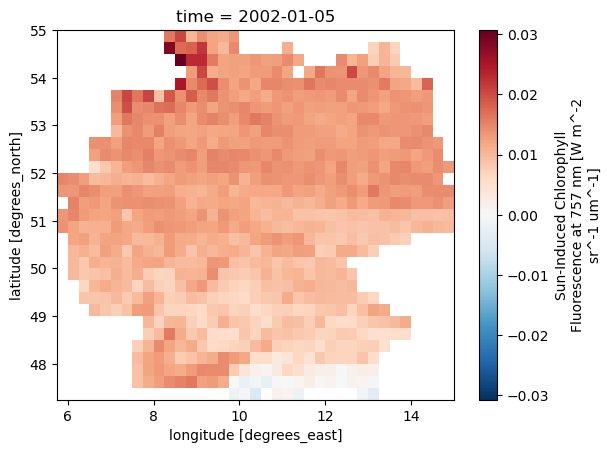

In [68]:
cube_ger_f_crop.isel(time=0).sif_gosif.plot()

In [61]:

# Create dataframe from cube
all_data_df = cube_ger_f_crop.to_dataframe().dropna()
all_data_df = all_data_df.dropna()


### Preprocess dataframe 

scale data and drop forest variables

In [62]:

variables = [
    "sif_gosif",
    "evaporation_era5",
    "precipitation_era5",
    "radiation_era5",
    "air_temperature_2m",
    "max_air_temperature_2m",
    "min_air_temperature_2m",
]


In [63]:
all_data_scaled, scalar_x, scalar_y = data_preprocess(all_data_df, variables)
all_data_scaled

,sif_gosif,evaporation_era5,precipitation_era5,radiation_era5,air_temperature_2m,max_air_temperature_2m,min_air_temperature_2m,time,lat,lon
0,-1.083664,1.347097,-1.188342,-0.959770,-3.253350,-2.531468,-3.357620,2002-01-05,47.375,9.875
1,-0.976883,1.373292,-1.096533,-1.278136,-1.518758,-1.672419,-1.668526,2002-01-05,52.375,8.125
2,-0.974599,1.355568,-1.087247,-1.281463,-1.521494,-1.669833,-1.732090,2002-01-05,52.375,8.375
3,-1.065111,1.375217,-1.053518,-0.970096,-2.840662,-2.357270,-3.074922,2002-01-05,47.625,12.625
4,-0.969862,1.339778,-1.063302,-1.281001,-1.522494,-1.672747,-1.752711,2002-01-05,52.375,8.625
...,...,...,...,...,...,...,...,...,...,...
763595,-0.941299,1.368476,-0.057878,-1.420631,-0.450864,-0.369745,-1.087510,2021-12-31,52.125,11.125
763596,-0.956356,1.382251,0.063661,-1.423236,-0.451635,-0.404656,-1.067127,2021-12-31,52.125,10.875
763597,-0.908224,1.400193,0.329970,-1.426882,-0.437109,-0.431621,-1.010070,2021-12-31,52.125,10.625
763598,-0.964082,1.363269,0.221260,-1.387140,-0.640855,-0.396947,-1.330811,2021-12-31,52.125,13.125


In [64]:
all_data_scaled = all_data_scaled.dropna()

In [65]:
all_data_scaled

,sif_gosif,evaporation_era5,precipitation_era5,radiation_era5,air_temperature_2m,max_air_temperature_2m,min_air_temperature_2m,time,lat,lon
0,-1.083664,1.347097,-1.188342,-0.959770,-3.253350,-2.531468,-3.357620,2002-01-05,47.375,9.875
1,-0.976883,1.373292,-1.096533,-1.278136,-1.518758,-1.672419,-1.668526,2002-01-05,52.375,8.125
2,-0.974599,1.355568,-1.087247,-1.281463,-1.521494,-1.669833,-1.732090,2002-01-05,52.375,8.375
3,-1.065111,1.375217,-1.053518,-0.970096,-2.840662,-2.357270,-3.074922,2002-01-05,47.625,12.625
4,-0.969862,1.339778,-1.063302,-1.281001,-1.522494,-1.672747,-1.752711,2002-01-05,52.375,8.625
...,...,...,...,...,...,...,...,...,...,...
763595,-0.941299,1.368476,-0.057878,-1.420631,-0.450864,-0.369745,-1.087510,2021-12-31,52.125,11.125
763596,-0.956356,1.382251,0.063661,-1.423236,-0.451635,-0.404656,-1.067127,2021-12-31,52.125,10.875
763597,-0.908224,1.400193,0.329970,-1.426882,-0.437109,-0.431621,-1.010070,2021-12-31,52.125,10.625
763598,-0.964082,1.363269,0.221260,-1.387140,-0.640855,-0.396947,-1.330811,2021-12-31,52.125,13.125


# 3. Model multiple timeseries with with local model using hyperparameter Tuning

In [66]:
lat_lon_pairs = all_data_scaled[["lat", "lon"]].drop_duplicates()


In [67]:
lat_lon_pairs

,lat,lon
0,47.375,9.875
1,52.375,8.125
2,52.375,8.375
3,47.625,12.625
4,52.375,8.625
...,...,...
825,54.875,9.125
826,54.875,8.875
827,54.625,13.625
828,54.875,9.375


In [37]:
lat_lon_pairs.iterrows()

<generator object DataFrame.iterrows at 0x7ff47ef97450>

In [49]:
lat_lon_pairs

,lat,lon
0,47.375,9.875
1,52.375,8.125
2,52.375,8.375
3,47.625,12.625
4,52.375,8.625
...,...,...
825,54.875,9.125
826,54.875,8.875
827,54.625,13.625
828,54.875,9.375


In [46]:
len(lat_lon_pairs)

830

In [45]:
for i, pair in enumerate(lat_lon_pairs.iterrows()):
    if i== 1:
       print(pair[1]["lat"])


52.375


In [29]:
# get unique paris 
unique_pairs = all_data_scaled[["lat", "lon"]].drop_duplicates()
unique_pairs

,lat,lon
0,47.375,9.875
1,52.375,8.125
2,52.375,8.375
3,47.625,12.625
4,52.375,8.625
...,...,...
825,54.875,9.125
826,54.875,8.875
827,54.625,13.625
828,54.875,9.375


Setting up logging

In [32]:
from datetime import date

today = date.today()

# dd/mm/YY
current_date = today.strftime("%d-%m-%Y")

In [33]:
logging.basicConfig(filename= f"logs/auto_modelling_{current_date}.log",level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s',)

In [34]:

# Hyperparameter Tuning with GridSearchCV
param_grid = {
    'units_lstm': [64, 128],
    'activation': ['relu', 'tanh'], 
    'epochs': [100],    
    'learning_rate': [0.0001],
    'dropout_rate': [0.2,0.4],
    'batch_size': [25],
    'num_lstm_layers': [1, 2, 3]
}

look_backs = [15,30,45]


results = []
evaluation = []
histories = []
best_params = []

number = len(unique_pairs)
output_data = {}

n_splits = 3

cv = TimeSeriesSplit(n_splits=n_splits)

Running the model

In [ ]:
print(2*"\n")
print(100*"-")
print(2*"\n")

print("Starting Modelling and GridsearchCV")


for look_back in look_backs:
            
    for i in range(10):

        
        lat, lon = unique_pairs.iloc[i]

        logging.info(f"Starting Grid Search for \n lat: {lat}\n lon: {lon}")

        trainX, trainY, valX, valY, testX, testY, test_index = split_data(
            all_data_scaled, lat, lon, look_back=look_back
        )

        # Create a KerasRegressor
        features = trainX.shape[2]
        model = create_keras_regressor(look_back, features)

        # Define GridSearchCV
        lstm_grid_search = GridSearchCV(
            estimator=model,
            param_grid=param_grid,
            cv=cv,
            scoring="neg_mean_squared_error",
            verbose=2,
            n_jobs=-1,
        )

        # Perform grid search
        lstm_grid_search.fit(
            trainX,
            trainY,
            epochs=epochs,
            batch_size=batch_size,
            verbose=0,
            callbacks=[EarlyStopping(monitor="val_loss", patience=5)],
            shuffle=False,
        )

        # Get the best model from the grid search
        best_params = lstm_grid_search.best_params_

        logging.info(f"Gridsearch done, The best parameters are: {best_params}")


        logging.info(f"Running and evaluating model")

        lstm_model = create_lstm_model(
            look_back=look_back,
            features=features,
            units_lstm=best_params['units_lstm'],
            activation=best_params['activation'],
            learning_rate=best_params['learning_rate'],
            dropout_rate=best_params['dropout_rate'],
            num_lstm_layers=best_params['num_lstm_layers']
        )

        history = lstm_model.fit(
            trainX,
            trainY,
            epochs=best_params['epochs'],
            batch_size=best_params['batch_size'],
            verbose=1,
            validation_data=(valX, valY)
        )


        forecasts = predict_replace(lstm_model, testX)

        testY_rescaled = scalar_y.inverse_transform(pd.DataFrame(testY))
        forecasts_rescaled = scalar_y.inverse_transform(pd.DataFrame(forecasts))


        rmse = root_mean_squared_error(testY_rescaled, forecasts_rescaled)
        mae = mean_absolute_error(testY_rescaled, forecasts_rescaled)

        results.append([testY_rescaled.tolist(), forecasts_rescaled.tolist()])
        evaluation.append({"lat": lat, "lon": lon, "mae": mae, "rmse": rmse})

        histories.append(history.history)


        # Add results to the output dictionary
        output_data[(lat, lon)] = {
            "best_params": best_params,
            "look_back":look_back,
            "evaluation": {"mae": mae, "rmse": rmse},
            "results": {"true_values": testY_rescaled.tolist(), "predicted_values": forecasts_rescaled.tolist()},
            "history": history.history
        }

        
        # Convert the entire data dictionary to a serializable format
        output_data_serializable = {str(k): convert_to_serializable(v) for k, v in output_data[(lat, lon)].items()}


        # Construct the output file path
        folder_name_json = f"result_jsons_l{look_back}"
        os.makedirs(folder_name_json, exist_ok=True)


        file_name_json = f"l{look_back}_{str(lat).replace('.', '_')}_{str(lon).replace('.', '_')}_model_results.json"
        output_json_file = os.path.join(folder_name_json, file_name_json)


        # Writing the converted data to 'model_results.json'
        with open(output_json_file, "w") as file:
            json.dump(output_data_serializable, file, indent=4)

        logging.info(f"Results and evaluation written to: {output_json_file}")

        logging.info(f"Completed {i + 1}/{len(unique_pairs)}")
        print(f"Completed {i + 1}/{len(unique_pairs)}")

        logging.info(100*"-")
        logging.info(100*"-")


    # Convert the entire data dictionary to a serializable format
    output_data_serializable = {str(k): convert_to_serializable(v) for k, v in output_data.items()}

    # Writing the converted data to 'model_results.json'
    with open(os.path.join(folder_name_json,f"results_auto_l{look_back}_relu.json"), "w") as file:
        json.dump(output_data_serializable, file, indent=4)

    print("Results and evaluation have been written to 'model_results.json'")


    print(2*"\n")
    print(100*"-")
    print(2*"\n")

# Testing Setup without autoregression


In [ ]:
reset_logging(f"logs/not_regressive_{current_date}.log")


In [ ]:
# Testing Setup without autoregression

print(2*"\n")
print(100*"-")
print(2*"\n")

print("Starting Modelling and GridsearchCV")




cv = TimeSeriesSplit(n_splits=n_splits)

for look_back in look_backs:

    for i in range(6):

        
        lat, lon = unique_pairs.iloc[i]

        logging.info(f"Starting non autoregressive Grid Search for \n lat: {lat}\n lon: {lon}")

        trainX, trainY, valX, valY, testX, testY, test_index = split_data(
            all_data_scaled, lat, lon, look_back=look_back, autoregressive=False
        )

        # Create a KerasRegressor
        features = trainX.shape[2]
        model = create_keras_regressor(look_back, features)

        # Define GridSearchCV
        lstm_grid_search = GridSearchCV(
            estimator=model,
            param_grid=param_grid,
            cv=cv,
            scoring="neg_mean_squared_error",
            verbose=2,
            n_jobs=-1,
        )

        # Perform grid search
        lstm_grid_search.fit(
            trainX,
            trainY,
            epochs=epochs,
            batch_size=batch_size,
            verbose=0,
            callbacks=[EarlyStopping(monitor="val_loss", patience=5)],
            shuffle=False,
        )

        # Get the best model from the grid search
        best_params = lstm_grid_search.best_params_

        logging.info(f"Gridsearch done, The best parameters are: {best_params}")


        logging.info(f"Running and evaluating model")

        lstm_model = create_lstm_model(
            look_back=look_back,
            features=features,
            units_lstm=best_params['units_lstm'],
            activation=best_params['activation'],
            learning_rate=best_params['learning_rate'],
            dropout_rate=best_params['dropout_rate'],
            num_lstm_layers=best_params['num_lstm_layers']
        )

        history = lstm_model.fit(
            trainX,
            trainY,
            epochs=best_params['epochs'],
            batch_size=best_params['batch_size'],
            verbose=1,
            validation_data=(valX, valY)
        )


        forecasts = predict_replace(lstm_model, testX, autoregressive=False)

        testY_rescaled = scalar_y.inverse_transform(pd.DataFrame(testY))
        forecasts_rescaled = scalar_y.inverse_transform(pd.DataFrame(forecasts))


        rmse = root_mean_squared_error(testY_rescaled, forecasts_rescaled)
        mae = mean_absolute_error(testY_rescaled, forecasts_rescaled)

        results.append([testY_rescaled.tolist(), forecasts_rescaled.tolist()])
        evaluation.append({"lat": lat, "lon": lon, "mae": mae, "rmse": rmse})

        histories.append(history.history)


        # Add results to the output dictionary
        output_data[(lat, lon)] = {
            "best_params": best_params,
            "look_back":look_back,
            "evaluation": {"mae": mae, "rmse": rmse},
            "results": {"true_values": testY_rescaled.tolist(), "predicted_values": forecasts_rescaled.tolist()},
            "history": history.history
        }

        
        # Convert the entire data dictionary to a serializable format
        output_data_serializable = {str(k): convert_to_serializable(v) for k, v in output_data[(lat, lon)].items()}

        # Construct the output file path
        folder_name_json = f"result_jsons_l{look_back}_noauto"
        os.makedirs(folder_name_json, exist_ok=True)


        file_name_json = f"l{look_back}_{str(lat).replace('.', '_')}_{str(lon).replace('.', '_')}_model_results_noauto.json"
        output_json_file = os.path.join(folder_name_json, file_name_json)


        # Writing the converted data to 'model_results.json'
        with open(output_json_file, "w") as file:
            json.dump(output_data_serializable, file, indent=4)

        logging.info(f"Results and evaluation written to: {output_json_file}")

        logging.info(f"Completed {i + 1}/{len(unique_pairs)}")
        print(f"Completed {i + 1}/{len(unique_pairs)}")

        logging.info(100*"-")
        logging.info(100*"-")



    # Convert the entire data dictionary to a serializable format
    output_data_serializable = {str(k): convert_to_serializable(v) for k, v in output_data.items()}

    # Writing the converted data to 'model_results.json'
    with open(os.path.join(folder_name_json,f"results_noauto_l{look_back}_relu.json"), "w") as file:
        json.dump(output_data_serializable, file, indent=4)

    print("Results and evaluation have been written to 'model_results.json'")


print(2*"\n")
print(100*"-")
print(2*"\n")

# Writing Results and testing results

In [ ]:
# Reading the results and evaluation from the file
with open("/home/luismaecker/team-extra/imke&luis&moritz/modelling_current/model_results_full.json", 'r') as file:
    loaded_data = json.load(file)


In [ ]:

# Extracting the loaded data
best_params = loaded_data['best_params']
evaluation = loaded_data['evaluation']
results = loaded_data['results']
history = loaded_data['history']



In [ ]:
lat, lon = unique_pairs.iloc[1]

trainX, trainY, valX, valY, testX, testY, test_index = split_data(
    all_data_scaled, lat, lon, look_back=look_back
)

In [ ]:
plot_multiple_results(results, evaluation, unique_pairs, look_back)

In [ ]:
plot_training(history)

# DICT PLOTTING

In [ ]:
import matplotlib.pyplot as plt

def plot_multiple_results(results_dict, time_index = test_index):
    num_plots = len(results_dict)
    num_cols = 2
    num_rows = (num_plots + 1) // num_cols

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 5))
    if num_rows * num_cols > 1:
        axes = axes.flatten()  # Flatten the axes array for easier iteration
    else:
        axes = [axes]  # Ensure axes is iterable

    for i, (lat_lon, data_dict) in enumerate(results_dict.items()):
        ax = axes[i]
        testY = data_dict['results']['true_values']
        forecasts = data_dict['results']['predicted_values']
        mae = data_dict['evaluation']['mae']
        rmse = data_dict['evaluation']['rmse']

        # Assuming lat_lon keys are in the format "(lat, lon)" and need to be converted from string
        lat, lon = eval(lat_lon)  # Convert the string key back to tuple if necessary

        # Generate a time index from the length of the testY data
        # time_index = range(len(testY))

        ax.plot(time_index, testY, label="Actual")
        ax.plot(time_index, forecasts, label="Predicted")
        ax.set_title(f"Lat: {lat}, Lon: {lon}")
        ax.set_xlabel("Time")
        ax.set_ylabel("Value")
        ax.legend()
        ax.grid(True)

        # Add MSE to the corner
        ax.text(0.95, 0.05, f"RMSE: {rmse:.2f}, MAE: {mae:.2f}", 
                verticalalignment='bottom', horizontalalignment='right', 
                transform=ax.transAxes, color='red', fontsize=12)

    # Adjust the layout to prevent overlap and make sure all plots are visible
    plt.tight_layout()
    plt.show()

# Example of calling the function with your dictionary of results
# plot_multiple_results(output_data)


In [ ]:
# Reading the results and evaluation from the file
with open("/home/luismaecker/team-extra/imke&luis&moritz/modelling_current/model_results_full.json", 'r') as file:
    loaded_data = json.load(file)


In [ ]:
lat

In [ ]:
str(lat).replace(".","_")

In [ ]:
plot_multiple_results(loaded_data, test_index[:-1])


# Creating Global Model

In [49]:
def split_data_glob(df_scaled, unique_pairs, look_back, target_col="sif_gosif", autoregressive=True):
    """
    Splits the scaled DataFrame into training, validation, and test sets for all specified locations and look-back periods.
    The timeframes for splitting are partly overlapping as to model timestep t, the timesteps from t to t-lookback are needed.

    Parameters:
    df_scaled (DataFrame): Preprocessed and scaled DataFrame.
    unique_pairs (DataFrame): DataFrame containing unique pairs of latitudes and longitudes.
    look_back (int): Number of past observations each input sample should consist of.

    Returns:
    tuple: Arrays of features and target variables for training, validation, and test datasets, and pixel indices.
    """
    combined_data = pd.DataFrame()
    pixel_indices = {}

    for idx, (lat, lon) in unique_pairs.iterrows():
        pixel_data = df_scaled.loc[(df_scaled["lat"] == lat) & (df_scaled["lon"] == lon)]
        #combined_data = pd.concat([combined_data, pixel_data])
        pixel_indices[(lat, lon)] = pixel_data.index

    combined_data = df_scaled.sort_values(by=["time", "lat", "lon"])

    first_index_2017 = combined_data[combined_data["time"].dt.year == 2017].index[0]
    val_end_index = first_index_2017 + look_back

    train_data = combined_data[combined_data["time"].dt.year <= 2014]

    val_data = combined_data[
        (combined_data["time"].dt.year == 2015) | 
        (combined_data["time"].dt.year == 2016) | 
        ((combined_data["time"].dt.year == 2017) & (combined_data.index < val_end_index))
    ]

    test_data = combined_data[
        (combined_data.index >= val_end_index) |
        (combined_data["time"].dt.year >= 2018)
    ]

    train = train_data.drop(columns=["time", "lat", "lon"])
    val = val_data.drop(columns=["time", "lat", "lon"])
    test = test_data.drop(columns=["time", "lat", "lon"])

    trainX, trainY = convert_to_matrix(train, look_back, target_col, autoregressive=autoregressive)
    valX, valY = convert_to_matrix(val, look_back, target_col, autoregressive=autoregressive)
    testX, testY = convert_to_matrix(test, look_back, target_col, autoregressive=autoregressive)

    trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], trainX.shape[2]))
    valX = np.reshape(valX, (valX.shape[0], valX.shape[1], valX.shape[2]))
    testX = np.reshape(testX, (testX.shape[0], testX.shape[1], testX.shape[2]))

    test_index = sorted(list(set(test_data.time)))

    return trainX, trainY, valX, valY, testX, testY, test_index, pixel_indices


In [50]:
# Testing Setup without autoregression

print(2*"\n")
print(100*"-")
print(2*"\n")

print("Starting splitting")



n_splits = 2

cv = TimeSeriesSplit(n_splits=n_splits)

look_back = 30
 


trainX, trainY, valX, valY, testX, testY, test_index, pixel_indices = split_data_glob(
    all_data_scaled, unique_pairs = unique_pairs, look_back=look_back, autoregressive=False
)





----------------------------------------------------------------------------------------------------



Starting splitting


In [61]:
print(trainX.shape,valX.shape, testX.shape)

(46613, 30, 6) (7246, 30, 6) (17808, 30, 6)


In [67]:
int(testX.shape[0]) + int(valX.shape[0]) + int(trainX.shape[0])

71667

In [57]:
all_data_scaled

,sif_gosif,evaporation_era5,precipitation_era5,radiation_era5,air_temperature_2m,max_air_temperature_2m,min_air_temperature_2m,time,lat,lon
0,-1.011922,1.248912,-1.180376,-0.826753,-1.925783,-1.800210,-1.667825,2002-01-05,47.625,7.625
1,-1.009902,1.367647,-1.089934,-1.273543,-2.339386,-1.955863,-2.981955,2002-01-05,50.125,9.875
2,-0.985991,1.319931,-1.075546,-1.220842,-1.901189,-1.884916,-1.989540,2002-01-05,50.375,6.875
3,-1.004664,1.381150,-0.963128,-1.198117,-2.520454,-2.205761,-2.930598,2002-01-05,48.875,13.625
4,-0.988567,1.377211,-1.040038,-1.240012,-2.166432,-1.972878,-2.397991,2002-01-05,50.375,10.875
...,...,...,...,...,...,...,...,...,...,...
71755,-0.899450,1.381330,1.892409,-1.410915,-0.169287,-0.503028,-0.171374,2021-12-31,51.125,7.625
71756,-0.917507,1.459768,1.595228,-1.420709,-0.239737,-0.546264,-0.250604,2021-12-31,51.125,7.875
71757,-0.948588,1.523909,0.908647,-1.440518,-0.336157,-0.573856,-0.421814,2021-12-31,51.125,8.375
71758,-0.957456,1.553456,1.080570,-1.408002,-0.465537,-0.577041,-0.561901,2021-12-31,50.625,10.625


In [72]:

# Hyperparameter Tuning with GridSearchCV
param_grid = {
    'units_lstm': [64, 128],
    'activation': ['tanh'], 
    'epochs': [100],    
    'learning_rate': [0.0001],
    'dropout_rate': [0.2],
    'batch_size': [25],
    'num_lstm_layers': [1, 2]
}

results = []
evaluation = []
histories = []
best_params = []

number = len(unique_pairs)
output_data = {}

n_splits = 2

cv = TimeSeriesSplit(n_splits=n_splits)

In [73]:
look_back = 30

# Create a KerasRegressor
features = trainX.shape[2]
model = create_keras_regressor(look_back, features)

print("STarting gcv")
# Define GridSearchCV
lstm_grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=cv,
    scoring="neg_mean_squared_error",
    verbose=2,
    n_jobs=-1,
)

# Perform grid search
lstm_grid_search.fit(
    trainX,
    trainY,
    epochs=epochs,
    batch_size=batch_size,
    verbose=0,
    callbacks=[EarlyStopping(monitor="val_loss", patience=5)],
    shuffle=False,
)

# Get the best model from the grid search
best_params = lstm_grid_search.best_params_

logging.info(f"Gridsearch done, The best parameters are: {best_params}")


print("fitting model")

logging.info(f"Running and evaluating model")

lstm_model = create_lstm_model(
    look_back=look_back,
    features=features,
    units_lstm=best_params['units_lstm'],
    activation=best_params['activation'],
    learning_rate=best_params['learning_rate'],
    dropout_rate=best_params['dropout_rate'],
    num_lstm_layers=best_params['num_lstm_layers']
)

history = lstm_model.fit(
    trainX,
    trainY,
    epochs=best_params['epochs'],
    batch_size=best_params['batch_size'],
    verbose=1,
    validation_data=(valX, valY)
)


forecasts = predict_replace(lstm_model, testX, autoregressive=False)

testY_rescaled = scalar_y.inverse_transform(pd.DataFrame(testY))
forecasts_rescaled = scalar_y.inverse_transform(pd.DataFrame(forecasts))


rmse = root_mean_squared_error(testY_rescaled, forecasts_rescaled)
mae = mean_absolute_error(testY_rescaled, forecasts_rescaled)

results.append([testY_rescaled.tolist(), forecasts_rescaled.tolist()])
evaluation.append({"mae": mae, "rmse": rmse})

histories.append(history.history)


# Add results to the output dictionary
output_data = {
    "best_params": best_params,
    "look_back":look_back,
    "evaluation": {"mae": mae, "rmse": rmse},
    "results": {"true_values": testY_rescaled.tolist(), "predicted_values": forecasts_rescaled.tolist()},
    "history": history.history
}


# Convert the entire data dictionary to a serializable format
output_data_serializable = {str(k): convert_to_serializable(v) for k, v in output_data.items()}

# Construct the output file path
folder_name_json = f"result_jsons_l{look_back}_noauto_glob"
os.makedirs(folder_name_json, exist_ok=True)


file_name_json = f"l{look_back}__results_noauto_glob.json"
output_json_file = os.path.join(folder_name_json, file_name_json)


# Writing the converted data to 'model_results.json'
with open(output_json_file, "w") as file:
    json.dump(output_data_serializable, file, indent=4)


STarting gcv
Fitting 2 folds for each of 4 candidates, totalling 8 fits


2024-07-22 13:12:41.068836: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-22 13:12:41.068835: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-22 13:12:41.068835: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-22 13:12:41.068835: I tensorflow/core/platform/cpu_featu

[CV] END activation=tanh, batch_size=25, dropout_rate=0.2, epochs=100, learning_rate=0.0001, num_lstm_layers=1, units_lstm=64; total time=12.4min
[CV] END activation=tanh, batch_size=25, dropout_rate=0.2, epochs=100, learning_rate=0.0001, num_lstm_layers=1, units_lstm=128; total time=20.8min
[CV] END activation=tanh, batch_size=25, dropout_rate=0.2, epochs=100, learning_rate=0.0001, num_lstm_layers=1, units_lstm=64; total time=22.9min
[CV] END activation=tanh, batch_size=25, dropout_rate=0.2, epochs=100, learning_rate=0.0001, num_lstm_layers=2, units_lstm=64; total time=25.8min
[CV] END activation=tanh, batch_size=25, dropout_rate=0.2, epochs=100, learning_rate=0.0001, num_lstm_layers=1, units_lstm=128; total time=43.2min
[CV] END activation=tanh, batch_size=25, dropout_rate=0.2, epochs=100, learning_rate=0.0001, num_lstm_layers=2, units_lstm=128; total time=41.2min
[CV] END activation=tanh, batch_size=25, dropout_rate=0.2, epochs=100, learning_rate=0.0001, num_lstm_layers=2, units_lst

# Global autoregressive model

In [74]:
# Testing Setup without autoregression

print(2*"\n")
print(100*"-")
print(2*"\n")

print("Starting splitting")



n_splits = 2

cv = TimeSeriesSplit(n_splits=n_splits)

look_back = 30
 


trainX, trainY, valX, valY, testX, testY, test_index, pixel_indices = split_data_glob(
    all_data_scaled, unique_pairs = unique_pairs, look_back=look_back, autoregressive=True
)





----------------------------------------------------------------------------------------------------



Starting splitting


In [75]:
look_back = 30

# Create a KerasRegressor
features = trainX.shape[2]
model = create_keras_regressor(look_back, features)

print("STarting gcv")
# Define GridSearchCV
lstm_grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=cv,
    scoring="neg_mean_squared_error",
    verbose=2,
    n_jobs=-1,
)

# Perform grid search
lstm_grid_search.fit(
    trainX,
    trainY,
    epochs=epochs,
    batch_size=batch_size,
    verbose=0,
    callbacks=[EarlyStopping(monitor="val_loss", patience=5)],
    shuffle=False,
)

# Get the best model from the grid search
best_params = lstm_grid_search.best_params_

logging.info(f"Gridsearch done, The best parameters are: {best_params}")


print("fitting model")

logging.info(f"Running and evaluating model")

lstm_model = create_lstm_model(
    look_back=look_back,
    features=features,
    units_lstm=best_params['units_lstm'],
    activation=best_params['activation'],
    learning_rate=best_params['learning_rate'],
    dropout_rate=best_params['dropout_rate'],
    num_lstm_layers=best_params['num_lstm_layers']
)

history = lstm_model.fit(
    trainX,
    trainY,
    epochs=best_params['epochs'],
    batch_size=best_params['batch_size'],
    verbose=1,
    validation_data=(valX, valY)
)


forecasts = predict_replace(lstm_model, testX, autoregressive=True)

testY_rescaled = scalar_y.inverse_transform(pd.DataFrame(testY))
forecasts_rescaled = scalar_y.inverse_transform(pd.DataFrame(forecasts))


rmse = root_mean_squared_error(testY_rescaled, forecasts_rescaled)
mae = mean_absolute_error(testY_rescaled, forecasts_rescaled)

results.append([testY_rescaled.tolist(), forecasts_rescaled.tolist()])
evaluation.append({"mae": mae, "rmse": rmse})

histories.append(history.history)


# Add results to the output dictionary
output_data = {
    "best_params": best_params,
    "look_back":look_back,
    "evaluation": {"mae": mae, "rmse": rmse},
    "results": {"true_values": testY_rescaled.tolist(), "predicted_values": forecasts_rescaled.tolist()},
    "history": history.history
}


# Convert the entire data dictionary to a serializable format
output_data_serializable = {str(k): convert_to_serializable(v) for k, v in output_data.items()}

# Construct the output file path
folder_name_json = f"result_jsons_l{look_back}_noauto_glob"
os.makedirs(folder_name_json, exist_ok=True)


file_name_json = f"l{look_back}__results_noauto_glob.json"
output_json_file = os.path.join(folder_name_json, file_name_json)


# Writing the converted data to 'model_results.json'
with open(output_json_file, "w") as file:
    json.dump(output_data_serializable, file, indent=4)


STarting gcv
Fitting 2 folds for each of 4 candidates, totalling 8 fits


2024-07-22 15:38:11.150775: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-22 15:38:11.150775: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-22 15:38:11.152418: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-22 15:38:11.152816: I tensorflow/core/platform/cpu_featu

[CV] END activation=tanh, batch_size=25, dropout_rate=0.2, epochs=100, learning_rate=0.0001, num_lstm_layers=1, units_lstm=64; total time=12.1min
[CV] END activation=tanh, batch_size=25, dropout_rate=0.2, epochs=100, learning_rate=0.0001, num_lstm_layers=1, units_lstm=128; total time=23.0min
[CV] END activation=tanh, batch_size=25, dropout_rate=0.2, epochs=100, learning_rate=0.0001, num_lstm_layers=1, units_lstm=64; total time=24.6min
[CV] END activation=tanh, batch_size=25, dropout_rate=0.2, epochs=100, learning_rate=0.0001, num_lstm_layers=2, units_lstm=64; total time=23.7min
[CV] END activation=tanh, batch_size=25, dropout_rate=0.2, epochs=100, learning_rate=0.0001, num_lstm_layers=1, units_lstm=128; total time=44.3min
[CV] END activation=tanh, batch_size=25, dropout_rate=0.2, epochs=100, learning_rate=0.0001, num_lstm_layers=2, units_lstm=128; total time=42.8min
[CV] END activation=tanh, batch_size=25, dropout_rate=0.2, epochs=100, learning_rate=0.0001, num_lstm_layers=2, units_lst

# Old

# Lex

#### Create a plot
fig, ax = plt.subplots()

#### Plot the border with specified colors
germany_gpd.plot(ax=ax, edgecolor="red", facecolor="none")

#### Remove axis
ax.axis("off")
plt.savefig(
    "output/germany_border.png", bbox_inches="tight", pad_inches=0, transparent=True
)

cube_ger
np.nanmax(cube_ger.evaporation_era5)
cube_ger.rio.write_crs(4326, inplace=True)
cube_ger = cube_ger.rio.clip(
    germany_gpd.geometry.values, germany_gpd.crs, drop=False, all_touched=False
)
w = lexcube.Cube3DWidget(
    cube_ger.radiation_era5, cmap="viridis", vmin=0, vmax=1006265
)  #
w
wa = lexcube.Cube3DWidget(
    cube_ger.radiation_era5, cmap="inferno", vmin=0, vmax=1006265.8
)  #
wa
c = lexcube.Cube3DWidget(cube_ger.precipitation_era5, cmap="YlGnBu", vmin=0, vmax=20)  #
c
d = lexcube.Cube3DWidget(
    cube_ger.air_temperature_2m, cmap="cividis", vmin=0, vmax=25
)  #
d
w = lexcube.Cube3DWidget(
    cube_ger.air_temperature_2m, cmap="bamako_r", vmin=0, vmax=0.7
)  #
w
os.getcwd()
w.savefig(fname="sif_cube.png", include_ui=False, dpi_scale=2.0)